In [1]:
import os,sys,string, time
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
from importlib import reload

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions
from Utilities.ipython_exit import exit

print ('Success')

Success


# Reading in .pkl files

In [4]:
Params = {"Run":"run3", #The run number, so far either "run1" or "run3"
          "Load_single_file":True, #This will override everything else, put the desired file in the "single_file" line
          "single_file":"overlay",
          "Load_standard_bkgs":True,
          "Load_DetVars":False,
          "Only_keep_common_DetVar_evs":True,
          "Load_Signal_DetVars":False,
          "Load_pi0_signal_DetVars":False,
          "Load_lepton_dirac":False,
          "Load_pi0_dirac":False,
          "Load_data":True,
          "FLATTEN":False, #Have one row per reconstructed object in the analysis dataframe
          "only_presel":True, #Create small files containing only variables necessary for pre-selection, for making pre-selection plots
          "Load_truth_vars":False,
          "Load_lepton_signal":True,
          "Load_pi0_signal":False}

Params, samples = Functions.create_sample_list(Params)
loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/"+Params["variables_string"]+"/"

Loading these run3 samples: 
['overlay']


In [5]:
samples_dict = {}

for sample in samples:
    if sample in Constants.Detector_variations:
        file = pd.read_pickle(loc_pkls+"DetVars/overlay_"+Params["Run"]+"_"+Params["variables_string"]+f"_{sample}_"+Params["Flat_state"]+"_"+Params["Reduced_state"]+".pkl")
        samples_dict[sample] = file
    if Params["Load_Signal_DetVars"] == True:
        file = pd.read_pickle(loc_pkls+"Signal_DetVars/"+Params["Run"]+f"_{sample}_"+Params["Reduced_state"]+".pkl")
        samples_dict[sample] = file
    else:
        if sample == 'signal':
            for HNL_mass in Constants.HNL_mass_samples:
                file = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_New_gen.pkl")
                samples_dict[HNL_mass] = file
        elif sample == 'pi0_signal':
            for HNL_mass in Constants.HNL_mass_pi0_samples:
                file = pd.read_pickle(loc_pkls+f"{sample}_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_New_gen.pkl")
                samples_dict[str(HNL_mass)+"_pi0"] = file
        elif (Params["Load_single_file"] == True) and (isinstance(sample,int)):
            HNL_mass = sample
            file = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_New_gen.pkl")
            samples_dict[HNL_mass] = file
        else: 
            file = pd.read_pickle(loc_pkls+f"{sample}_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_FINAL.pkl")
            samples_dict[sample] = file

print(samples_dict.keys())

dict_keys(['overlay'])


## Reading in overlay .root file with the reweight branches

In [7]:
Run = Params["Run"]
sys_variables = Variables.sys_vars + Variables.event_vars + Variables.weight_related

if Run == "run1":
    NuMI_MC_overlay = uproot3.open('../NuMI_MC/SLIMMED_neutrinoselection_filt_run1_overlay.root')['nuselection/NeutrinoSelectionFilter']
    Norm = Constants.SF_overlay_run1
elif Run == "run3":
    NuMI_MC_overlay = uproot3.open('../NuMI_MC/SLIMMED_neutrinoselection_filt_run3_overlay.root')['nuselection/NeutrinoSelectionFilter']
    Norm = Constants.SF_overlay_run3

df_overlay_weights = NuMI_MC_overlay.pandas.df(sys_variables, flatten=False) #Perhaps I can do this in a more clever way than just making a dataframe


In [8]:
def Apply_swtrig(df):
    query="swtrig_pre>0"
    df.query(query)

def Apply_flash_shift(df, sample_type):
    #Only required for beam off, overlay, dirtoverlay and signal (i.e all except beamon data)
    if(sample_type=="beamoff"): df["flash_time"]=df["flash_time"] -0.359
    else: df["flash_time"]=df["flash_time"] - 0.304
    
Pre_swtrig_dict = {}
swtrig = {}
apply_swtrig = True

for sample in samples_dict:
    Pre_swtrig_dict[sample] = len(samples_dict[sample]) #Should weight this properly, i.e take sum of weights for the total number.
    if(apply_swtrig):
        swtrig[sample] = samples_dict[sample].query("swtrig_pre>0")
    if sample != "beamgood":
        Apply_flash_shift(samples_dict[sample], sample)
        
cut_dict = Constants.Preselection_dict_for_plot
        
samples_dict["overlay"]=samples_dict["overlay"].query(cut_dict['nslice'])
print("Made nslice cut")

Made nslice cut


## Calculate systematic error

In [9]:
print(samples_dict['overlay'].keys())

Index(['nslice', 'flash_time', 'nu_flashmatch_score', 'NeutrinoEnergy2',
       'contained_fraction', 'trk_score', 'trk_score_v', 'n_pfps',
       'swtrig_pre', 'swtrig_post', 'crtveto', 'weightSplineTimesTune',
       'ppfx_cv', 'npi0', 'run', 'sub', 'evt', 'weight'],
      dtype='object')


In [10]:
samples_dict['overlay'].head()

,nslice,flash_time,nu_flashmatch_score,NeutrinoEnergy2,contained_fraction,trk_score,trk_score_v,n_pfps,swtrig_pre,swtrig_post,crtveto,weightSplineTimesTune,ppfx_cv,npi0,run,sub,evt,weight
entry,,,,,,,,,,,,,,,,,,
0,1,10.332250,6.991224,132.850189,0.0,-3.402823e+38,[0.9768751],1,1,1,0,0.001616,0.841061,0,17080,27,1373,0.001359
3,1,7.872251,1.371310,451.179077,0.0,-3.402823e+38,"[0.99995583, 0.96434164]",2,1,1,1,1.000000,0.614260,0,17080,27,1381,0.614260
4,1,11.866000,3.029482,270.353119,0.0,-3.402823e+38,"[0.30477512, 0.97554344]",2,1,1,0,1.164057,0.808461,0,17080,27,1382,0.941095
5,1,12.852250,1.448333,291.633942,0.0,-3.402823e+38,[0.9997782],1,1,1,0,1.089981,1.099046,0,17080,27,1387,1.197940
7,1,8.562250,5.066216,113.655708,1.0,9.714050e-01,[0.971405],1,1,1,0,1.154199,1.084669,0,17080,27,1400,1.251924


In [11]:
#Calculate sys
variable = 'nslice'

# Norm = sample_norms["overlay"]
if Params["Run"] == "run1":Norm = Constants.SF_overlay_run1
if Params["Run"] == "run3":Norm = Constants.SF_overlay_run3

xlims = [-0.5,1.5]
nbins = 2
BINS = np.linspace(xlims[0],xlims[1], nbins)


In [12]:
results_dict_ppfx=Functions.All_reweight_err(samples_dict["overlay"],"weightsPPFX",variable,BINS,xlims,Norm)

print(f"Calculated ppfx uncertainty")

KeyError: 'weightsPPFX'

In [13]:
results_dict_genie=Functions.All_reweight_err(samples_dict["overlay"],"weightsGenie",variable,BINS,xlims,Norm)

print(f"Calculated genie uncertainty")

KeyError: 'weightsGenie'

In [9]:
cov_ppfx = results_dict_ppfx["weightsPPFX"][0]
cov_genie = results_dict_genie["weightsGenie"][0]
var_Overlay = samples_dict["overlay"][variable]
# print(cov_PPFX)
overlaybkg=np.histogram(var_Overlay,bins=BINS,range=xlims)[0]

weight_Overlay=samples_dict["overlay"]["weight"]*Norm
#weighted hists
overlaybkg_weighted=np.histogram(var_Overlay,bins=BINS,range=xlims,weights=weight_Overlay)[0]

mc_w=np.histogram(var_Overlay,bins=BINS,range=xlims,weights=weight_Overlay**2)

mc_err=np.sqrt(mc_w[0])

# stat_bkgerr=np.sqrt(offbkg_stat**2+overlaybkg_stat**2+dirtbkg_stat**2) #Adding stat errors in quadrature, my way
stat_bkgerr=mc_err #Adding stat errors in quadrature

cov_mc_stat   = np.zeros([len(stat_bkgerr), len(stat_bkgerr)])
cov_mc_stat[np.diag_indices_from(cov_mc_stat)]=stat_bkgerr**2 #Don't actually need here

tot_ppfx_err=np.sqrt(np.diag(cov_ppfx))
tot_genie_err=np.sqrt(np.diag(cov_genie))
tot_mcerr = np.sqrt(np.diag(cov_ppfx+cov_genie))

print(tot_mcerr)
print(stat_bkgerr)

[13214.35622166]
[166.38098]


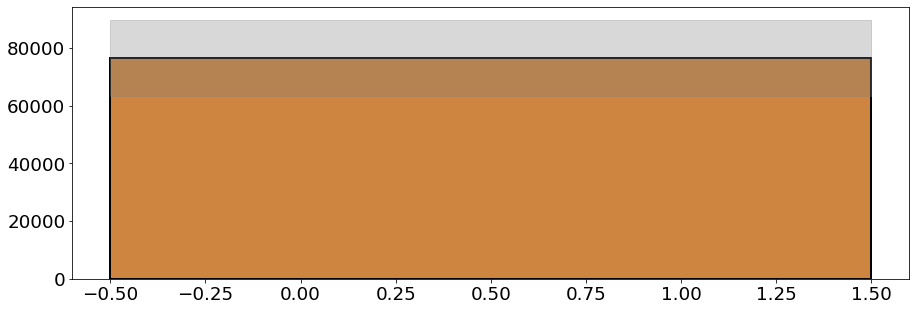

In [10]:
varis=[var_Overlay]
weights=[weight_Overlay]
colors=['peru']
labels=[fr"In-Cryo $\nu$"]

x,y=np.histogram(var_Overlay,bins=BINS,range=xlims,density=False)
x1,y=np.histogram(var_Overlay,bins=BINS,range=xlims)

plot=plt.hist(varis,
          label=labels,
          range=xlims,bins=BINS,
          histtype="stepfilled",
          stacked=True,density=False,linewidth=2,edgecolor="black",
          weights=weights, color=colors)

upvals=np.append((plot[0]+tot_mcerr),(plot[0]+tot_mcerr)[-1])
lowvals=np.append((plot[0]-tot_mcerr),(plot[0]-tot_mcerr)[-1])

plt.fill_between(y, lowvals, upvals,step="post",color="grey",alpha=0.3,zorder=2)

## Check fraction is flat across distribution

[0.1728543]


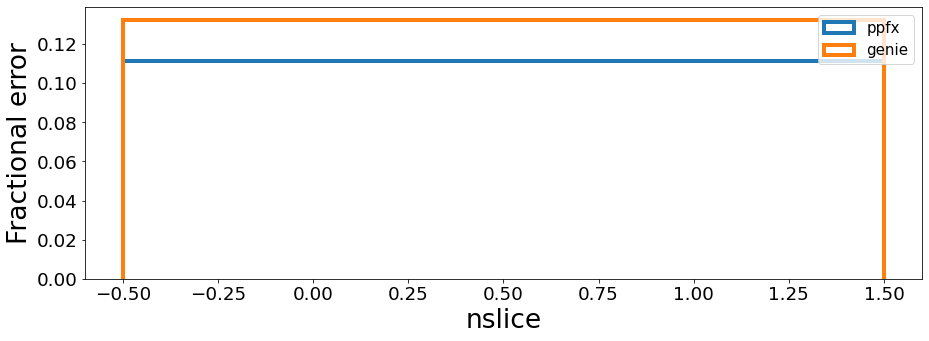

In [11]:
frac = np.divide(tot_mcerr, plot[0])
frac_ppfx = np.divide(tot_ppfx_err, plot[0])
frac_genie = np.divide(tot_genie_err, plot[0])
print(frac)

bins_cent=(BINS[:-1]+BINS[1:])/2
plt.hist(bins_cent,weights=np.nan_to_num(frac_ppfx),bins=BINS,range=xlims,density=False, label="ppfx", histtype="step", lw=4)
plt.hist(bins_cent,weights=np.nan_to_num(frac_genie),bins=BINS,range=xlims,density=False, label="genie",  histtype="step", lw=4)
plt.legend()

plt.xlabel(variable)
plt.ylabel(f"Fractional error")
plt.savefig("plots/Data_MC_comparison/Overlay_sys_unc/" + Params["Run"] + f"_{variable}_ppfx_and_genie_frac_err.png")

In [12]:
#Calculate average
length = len(frac)
total = sum(np.nan_to_num(frac))
total_ppfx = sum(np.nan_to_num(frac_ppfx))
total_genie = sum(np.nan_to_num(frac_genie))

mean = total/length
mean_ppfx = total_ppfx/length 
mean_genie = total_genie/length 

print(Params["Run"])

print(f"mean ppfx is {mean_ppfx}")
print(f"mean genie is {mean_genie}")

run3
mean ppfx is 0.11114184119926775
mean genie is 0.13238618067476998
